## Using the following packages:

* pip install python-igraph
* pip install partition-igraph
* pip install hypernetx


In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import partition_igraph
import hypernetx as hnx
import pickle
import hypernetx.algorithms.hypergraph_modularity as hmod

# Summary of functions for Hypergraph Modularity using HNX

### Build hypergraph and pre-compute key quantities

We build the hypergraph HG using:
```python
HG = hnx.Hypergraph(Edges)
```
where 'Edges' is a list of sets; edges are then indexed as 0-based integers.

Once the HNX hypergraph is built, the following function is called to 
compute node strengths, d-degrees and binomial coefficients
and add these as attributes to HG:

```python
hmod.precompute_attributes(HG)
```

### Partitions

We use two representations for partitions: list of sets (the parts) or dictionary.
Those functions are used to map from one to the other:

```python
dict2part(D)
part2dict(A)
```

### H-modularity

The function to compute H-modularity for HG w.r.t. partition A (list of sets covering the vertices):

```python
hmod.hypergraph_modularity(HG, A, wcd=linear)
```

where 'wcd' is the weight function (default = 'linear'). Other choices are 'strict'
and 'majority', or any user-supplied function with the following format:

```python
def linear(d,c):
    return c/d if c>d/2 else 0
```

where $d$ is the edge size, and $c$ is the number of nodes in the majority class, $d \geq c > \frac{d}{2}$

### Two-section graph

Build the random-walk based $2$-section graph given some hypergraph HG:

```python
G = hmod.two_section(HG)
```

where G is an igraph Graph.

### Clustering: Kumar algorithm

Given hypergraph HG, compute a partition of the vertices as per Kumar's algorithm described in [1].

```python
K = hmod.kumar(HG, delta=.01)
```

where delta is the convergence stopping criterion. Partition is returned as a dictionary.

[1] Kumar T., Vaidyanathan S., Ananthapadmanabhan H., Parthasarathy S., Ravindran B. (2020) *A New Measure of Modularity in Hypergraphs: Theoretical Insights and Implications for Effective Clustering*. In: Cherifi H., Gaito S., Mendes J., Moro E., Rocha L. (eds) Complex Networks and Their Applications VIII. COMPLEX NETWORKS 2019. Studies in Computational Intelligence, vol 881. Springer, Cham. https://doi.org/10.1007/978-3-030-36687-2_24


### Clustering: Simple qH-based algorithm

Given hypergraph HG and initial partition L, 
compute a partition of the vertices as per Last-Step algorithm described in [2].

```python
A = hmod.last_step(HG, L, wdc=linear, delta = .01)
```

where 'wcd' is the the weight function (default = 'linear') and delta is the convergence stopping criterion.
Returned partition is a list of sets.

[2] B. Kaminski, P. Pralat and F. Théberge, *Community Detection Algorithm Using Hypergraph Modularity*, to appear in the proceedings of Complex Networks 2020, Springer.


# Toy example

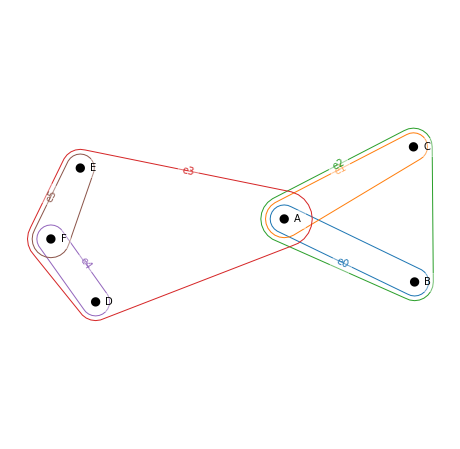

In [2]:
## build a hypergraph from a list of sets (the hyperedges)
E = [{'A','B'},{'A','C'},{'A','B','C'},{'A','D','E','F'},{'D','F'},{'E','F'}]
HG = hnx.Hypergraph(E,static=True)
hnx.draw(HG)


In [3]:
## compute node strength (add unit weight is none), d-degrees, binomial coefficients
hmod.precompute_attributes(HG)

In [4]:
## the edges (unit weights added by default)
HG.edges.elements


{'e0': ['A', 'B'],
 'e1': ['C', 'A'],
 'e2': ['C', 'A', 'B'],
 'e3': ['F', 'A', 'D', 'E'],
 'e4': ['D', 'F'],
 'e5': ['E', 'F']}

In [5]:
## the nodes (here strength = degree since all weights are 1)
HG.nodes.elements


{'A': [], 'B': [], 'C': [], 'F': [], 'D': [], 'E': []}

In [6]:
HG.d_weights


Counter({2: 4, 3: 1, 4: 1})

In [7]:
## compute modularity qH for the following partitions:
A1 = [{'A','B','C'},{'D','E','F'}]
A2 = [{'B','C'},{'A','D','E','F'}]
A3 = [{'A','B','C','D','E','F'}]
A4 = [{'A'},{'B'},{'C'},{'D'},{'E'},{'F'}]

strict = hmod.strict
majority = hmod.majority

print('linear:',hmod.modularity(HG,A1),hmod.modularity(HG,A2),hmod.modularity(HG,A3),hmod.modularity(HG,A4))
print('strict:',hmod.modularity(HG,A1,strict),hmod.modularity(HG,A2,strict),hmod.modularity(HG,A3,strict),hmod.modularity(HG,A4,strict))
print('majority:',hmod.modularity(HG,A1,majority),hmod.modularity(HG,A2,majority),hmod.modularity(HG,A3,majority),hmod.modularity(HG,A4,majority))


linear: 0.414445267489712 -0.03746831275720153 0.0 -0.19173004115226341
strict: 0.43490699588477366 -0.02385843621399164 0.0 -0.12887572016460908
majority: 0.39379753086419755 -0.0343506172839505 0.0 -0.22078024691358022


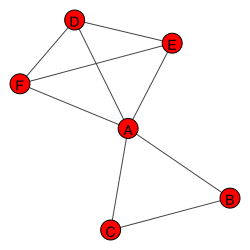

In [8]:
## 2-section graph
G = hmod.two_section(HG)
G.vs['label'] = G.vs['name']
ig.plot(G,bbox=(0,0,250,250))


In [9]:
## 2-section clustering with ECG
G.vs['community'] = G.community_ecg().membership
hmod.dict2part({v['name']:v['community'] for v in G.vs})


[{'A', 'B', 'C'}, {'D', 'E', 'F'}]

In [10]:
## Clustering with Kumar's algorithm
hmod.dict2part(hmod.kumar(HG))

[{'A', 'B', 'C'}, {'D', 'E', 'F'}]

In [11]:
## hypergraph clustering -- start from partition A4 defined above
print('start from:',A4)
A = hmod.last_step(HG,A4)
print('final partition:',A)


start from: [{'A'}, {'B'}, {'C'}, {'D'}, {'E'}, {'F'}]
final partition: [{'C', 'A', 'B'}, {'D', 'E', 'F'}]


# Game of Thrones scenes hypergraph

REF: https://github.com/jeffreylancaster/game-of-thrones

We built an hypergraph from the game of thrones scenes with he following elements:

* **Nodes** are characters in the series
* **Hyperedges** are groups of character appearing in the same scene(s)
* **Hyperedge weights** are total scene(s) duration in seconds involving those characters

We kept hyperedges with at least 2 characters.
Moreover, we discarded characters with degree below 5.

We saved the following:

* *Edges*: list of sets where the nodes are 0-based integers represents as strings
* *Names*: dictionary; mapping of nodes to character names
* *Weights*: list; hyperedge weights (in same order as Edges)


In [12]:
## load the GoT dataset
Edges, Names, Weights = pickle.load(open( "../hypernetx/utils/toys/GoT.pkl", "rb" ))

## Build weighted hypergraph 

In [13]:
## Nodes are represented as strings from '0' to 'n-1'
HG = hnx.Hypergraph(dict(enumerate(Edges)))
## add edge weights
for e in HG.edges:
    HG.edges[e].weight = Weights[e]
## add full names
for v in HG.nodes:
    HG.nodes[v].name = Names[v]
## pre-compute required quantities for modularity and clustering
hmod.precompute_attributes(HG)

### Modularity (qH) on a random partition

Should be close to 0 and can be negative.

In [14]:
## generate a random partition into K parts to compare results
K = 5
V = list(HG.nodes)
p = np.random.choice(K, size=len(V))
RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
## compute qH
hmod.modularity(HG, RandPart)

-0.032074856299121574

### Get the 2-section graph (with igraph) and cluster with Louvain


In [15]:
## build 2-section
G = hmod.two_section(HG)
## Louvain algorithm
ML = G.community_multilevel(weights='weight')
G.vs['louvain'] = ML.membership
part = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})
## Compute qH
print(hmod.modularity(HG, part))

0.5372359319251633


### Cluster with Kumar's algorithm


In [16]:
## run Kumar's algorithm, get partition
KU = hmod.kumar(HG)
G.vs['kumar'] = [KU[v['name']] for v in G.vs]
## Compute qH
print(hmod.modularity(HG, hmod.dict2part(KU)))

0.5351500884869287


### Cluster with simple H-based (Last Step) Algorithm

We use Louvain or Kumar algorithm on the 2-section as the required initial partition

In [17]:
## Louvain parition already computed
part = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})
## H-based last step
LS = hmod.last_step(HG, part)
## Compute qH
hmod.modularity(HG, LS)


0.5475162906819371

### Example: top nodes in cluster with Daenerys Targaryen


In [18]:
## Index for 
inv_map = {v: k for k, v in Names.items()}
JS = inv_map['Daenerys Targaryen']
## JS's cluster
JS_part = hmod.part2dict(LS)[JS]
## Build dataframe: all nodes in JS_part
L = []
for n in LS[JS_part]:
    L.append([Names[n],HG.nodes[n].strength])
D = pd.DataFrame(L, columns=['character','strength'])
D.sort_values(by='strength',ascending=False).head(5)

,character,strength
15,Daenerys Targaryen,31103
24,Jorah Mormont,19344
7,Missandei,13683
4,Grey Worm,10497
11,Barristan Selmy,6514
